In [9]:
from dotenv import load_dotenv
import os
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langchain.chat_models.base import BaseChatModel
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
load_dotenv()

True

In [10]:
memory = MemorySaver()

In [2]:
llm: BaseChatModel = ChatGroq(
    temperature=0,
    model_name="llama-3.3-70b-versatile",  # or "llama2-70b-4096"
    groq_api_key=os.getenv("GROQ_API_KEY")
)

In [3]:
@tool
def get_stock_price(symbol: str) -> float:
    """
    Get the latest stock price for a given symbol.
    Supported symbols: MSFT, AAPL, AMZN, RIL.
    """
    return {
        "MSFT" : 200.3,
        "AAPL" : 100.4,
        "AMZN" : 150.0,
        "RIL"  : 87.7
    }.get(symbol, 0.0)

tools = [get_stock_price]

In [4]:
llm_with_tools = llm.bind_tools(tools)

In [11]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)
builder.add_edge("tools","chatbot_node")
builder.add_edge("chatbot_node", END)

graph = builder.compile(checkpointer=memory)

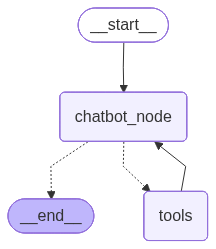

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
message = {"role":"user","content":"What is the price of AMZN stock right now?"}
response = graph.invoke({"messages": [message]})
print(response["messages"][-1].content)

The current price of AMZN stock is $150.0.


In [13]:
config = {'configurable': {'thread_id': '1'}}

message = {"role":"user","content":"What is the price of 15 AMZN stock right now?"}
response = graph.invoke({"messages": [message]}, config = config)
print(response["messages"][-1].content)

The current price of 15 AMZN stock is $2250.00.


In [15]:
config2 = { 'configurable': { 'thread_id': '2'} }

msg = "Tell me the current price of 5 AAPL stocks."

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price of 5 AAPL stocks is 5 * 100.4 = 502.


In [16]:
msg = "Tell me the current price of 5 MSFT stocks and add it to previous total"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price of 5 MSFT stocks is 5 * 200.3 = 1001.5. Adding this to the previous total of 502, the new total is 1001.5 + 502 = 1503.5.
